# Cats vs Dogs

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Configure GPU
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print('Tensorflow version: ', tf.__version__)
print('Physical Devices: ', physical_devices)

Tensorflow version:  2.12.0
Physical Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading images

In [3]:
dir = 'train/'

for i, filename in enumerate(os.listdir(dir)):
    what = filename.split('.')[0]
    new_path = os.path.join(dir, what)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    elif i == 0:
        break # Files are already classified
    os.rename(os.path.join(dir, filename), os.path.join(new_path, filename))

### Generator

In [4]:
from keras.preprocessing.image import ImageDataGenerator

target_size = (224, 224, 3)
BATCH_SIZE = 64
SEED = 123

gen_train = ImageDataGenerator(validation_split=0.2, rotation_range=20, width_shift_range=0.15, height_shift_range=0.15,
                        shear_range=0.15, zoom_range=0.15)
gen_valid = ImageDataGenerator(validation_split=0.2)
training_data = gen_train.flow_from_directory(dir, target_size=target_size[:-1], batch_size=BATCH_SIZE, 
                                            class_mode='sparse', 
                                            subset='training',
                                            seed=SEED)
validation_data = gen_valid.flow_from_directory(dir, target_size=target_size[:-1], batch_size=BATCH_SIZE, 
                                                class_mode='sparse',
                                                subset='validation', 
                                                seed=SEED)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Some images

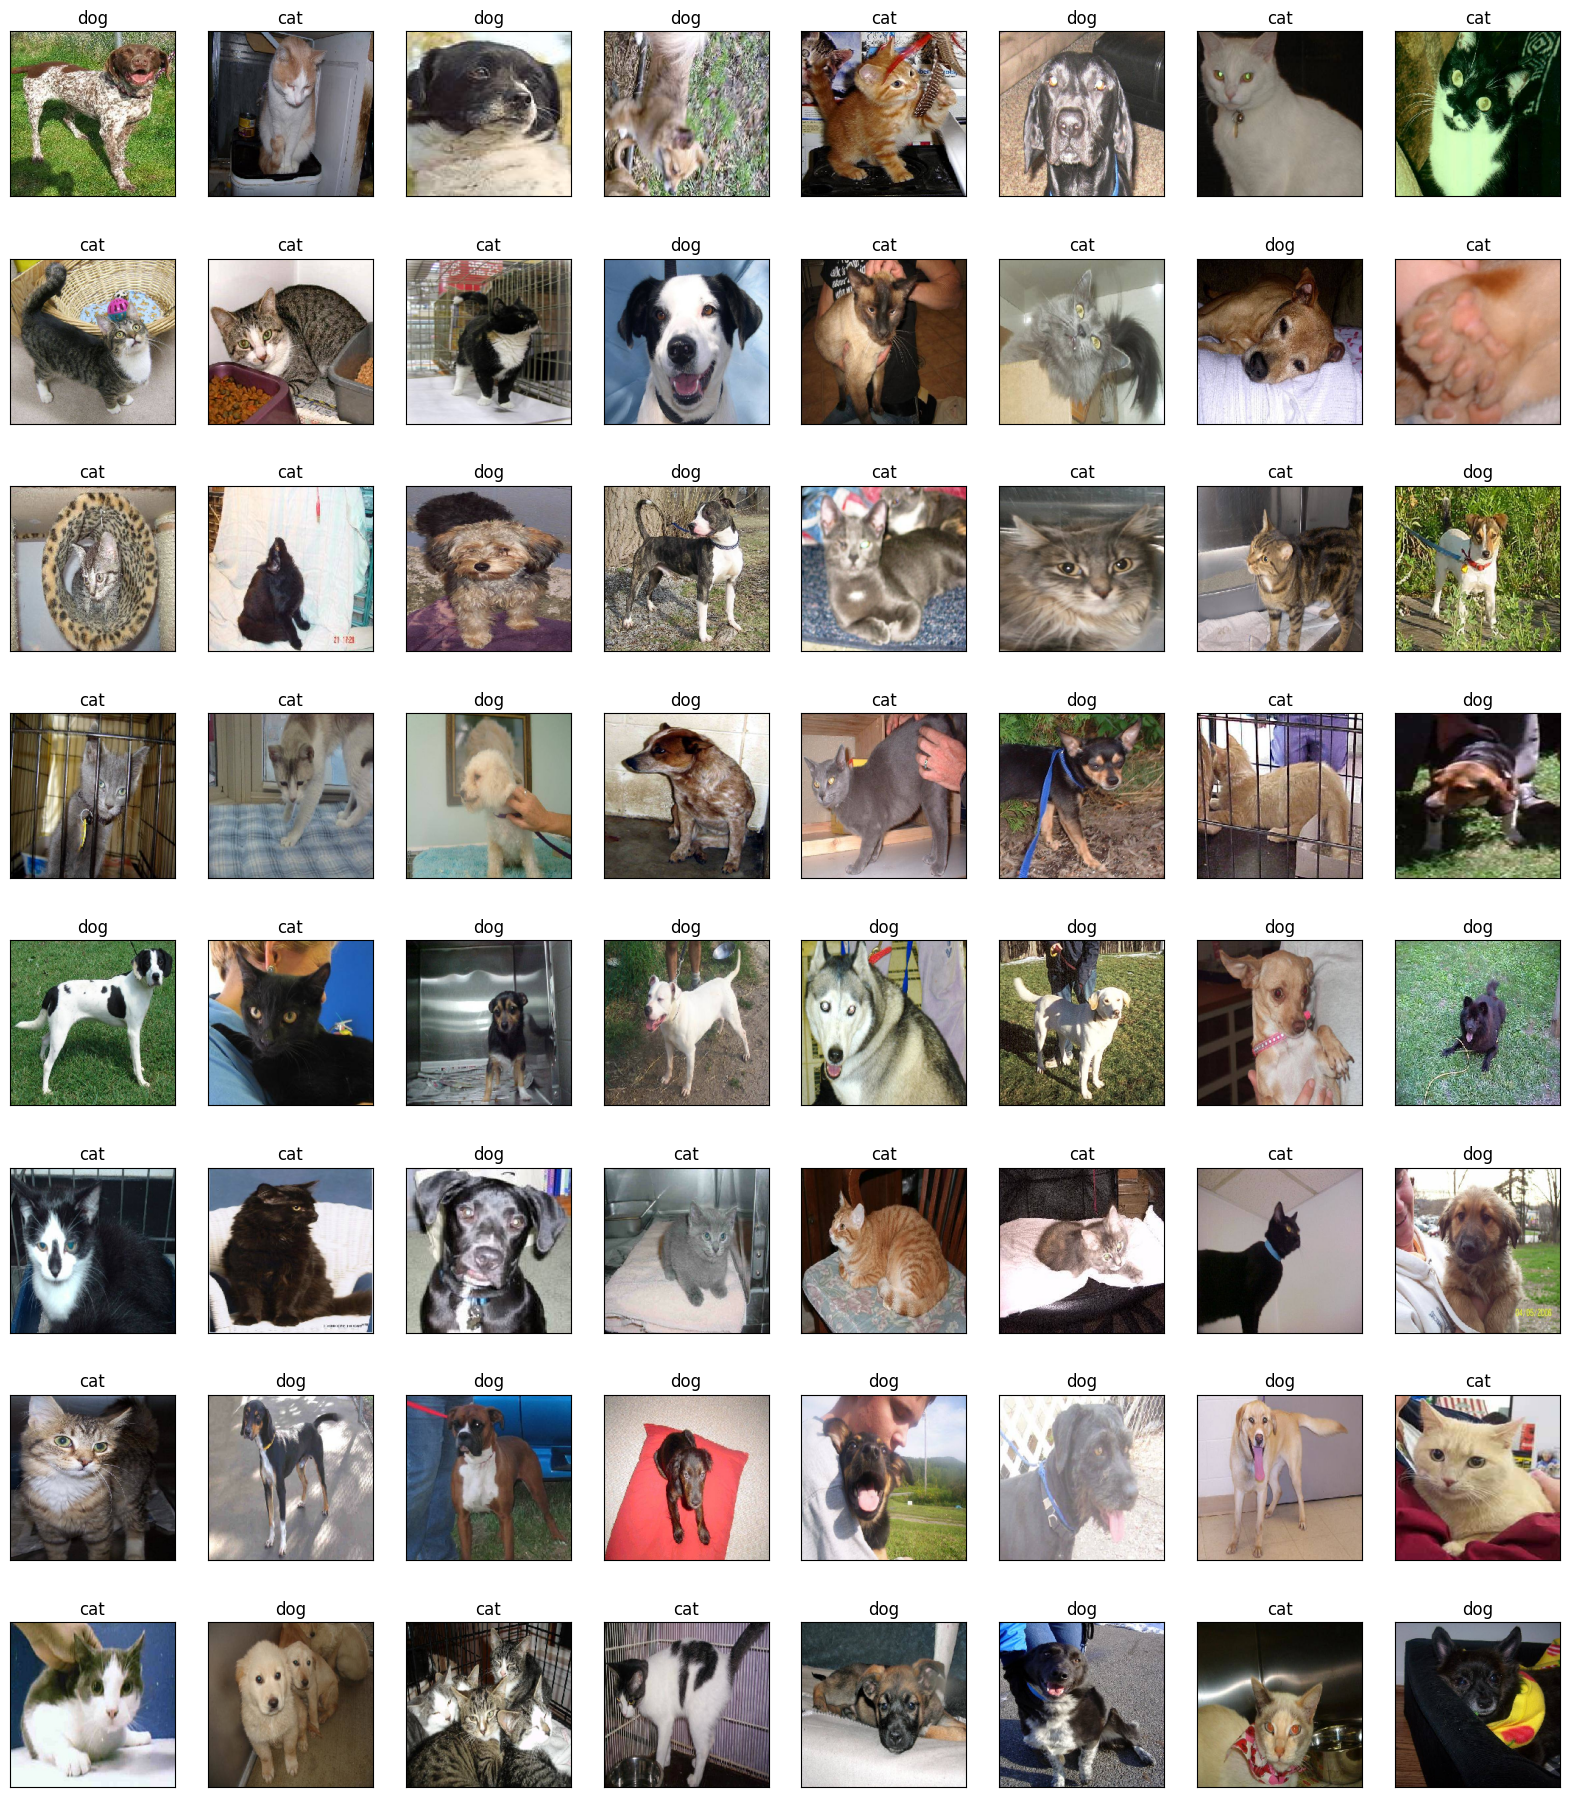

In [5]:
fig = plt.figure(figsize=(20, 20))
images, labels = next(validation_data)
i = 0
for image, label in zip(images, labels):
    axis = plt.subplot(8, 8, i + 1)
    axis.imshow(image / 255.)
    axis.set_title('cat' if label == 0 else 'dog')
    axis.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    i += 1

fig.subplots_adjust(top=1)

## Defining the model

In [6]:
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D

In [7]:
class ReLU(keras.layers.Layer):
    def __init__(self):
        super(ReLU, self).__init__()

    def call(self, input_tensor, training=False):
        return tf.maximum(input_tensor, 0)

In [8]:
class Normalization(keras.layers.Layer):
    def __init__(self):
        super(Normalization, self).__init__()

    def call(self, input_tensor, training=False):
        mu = tf.reduce_mean(input_tensor, axis=0, keepdims=True)
        std = tf.math.reduce_std(input_tensor, axis=0, keepdims=True)
        return (input_tensor - mu) / (std + 1e-8)

In [9]:
class ConvBlock(keras.layers.Layer):
    def __init__(self, filters=32, kernel_size=3):
        super(ConvBlock, self).__init__()

        self.conv = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')
        self.batch_norm = BatchNormalization(axis=-1)
        self.relu = ReLU()

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.batch_norm(x, training=training)
        return self.relu(x)

In [10]:
class ResBlock(keras.layers.Layer):
    def __init__(self, filters, has_pooling=True):
        super(ResBlock, self).__init__()

        self.has_pooling = has_pooling
        self.conv1 = ConvBlock(filters=filters[0])
        self.conv2 = ConvBlock(filters=filters[1])
        self.conv3 = ConvBlock(filters=filters[2])
        self.identity = Conv2D(filters=filters[1], kernel_size=1, padding='same')
        self.maxpooling = MaxPooling2D()

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor, training=training)
        x = self.conv2(x, training=training)
        skip_connection = self.identity(input_tensor)
        x = self.conv3(x + skip_connection, training=training)
        if self.has_pooling:
            x = self.maxpooling(x)
        return x

In [11]:
class Model(keras.Model):
    def __init__(self, input_shape):
        super(Model, self).__init__()

        # Define the base model
        self.base_model = keras.applications.ResNet50(include_top=False, input_shape=input_shape)
        self.base_model.trainable = False

        # Define layers
        self.norm = keras.applications.resnet.preprocess_input
        self.relu = ReLU()
        self.global_average_pooling = GlobalAveragePooling2D()
        self.dense1 = Dense(units=256)
        self.dense2 = Dense(128)
        self.res_block = ResBlock([512, 512, 1024])
        self.dropout = Dropout(0.2)
        self.classifier = Dense(units=1)

        # build the model
        self.build((None, ) + input_shape)

    def call(self, input_tensor, training=False):
        x = self.norm(input_tensor)
        x = self.base_model(x)
        x = self.res_block(x)
        x = self.global_average_pooling(x)
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.relu(self.dense2(x))
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [12]:
model = Model(target_size)

optimizer = tf.optimizers.Adam()
loss = tf.losses.BinaryCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               multiple                  262400    
                                                                 
 dense_1 (Dense)             multiple                  32896     
                                                                 
 res_block (ResBlock)        multiple                  17574400  
                                                             

In [13]:
with tf.device('GPU:0'):
    history = model.fit(training_data, validation_data=validation_data, epochs=10, verbose=1)

Epoch 1/10
313/313 [==============================] - 192s 581ms/step - loss: 0.0587 - accuracy: 0.9779 - val_loss: 0.0346 - val_accuracy: 0.9870
Epoch 2/10
313/313 [==============================] - 179s 571ms/step - loss: 0.0426 - accuracy: 0.9827 - val_loss: 0.0370 - val_accuracy: 0.9850
Epoch 3/10
313/313 [==============================] - 178s 569ms/step - loss: 0.0380 - accuracy: 0.9848 - val_loss: 0.0402 - val_accuracy: 0.9872
Epoch 4/10
313/313 [==============================] - 178s 568ms/step - loss: 0.0330 - accuracy: 0.9872 - val_loss: 0.0457 - val_accuracy: 0.9872
Epoch 5/10
313/313 [==============================] - 178s 569ms/step - loss: 0.0285 - accuracy: 0.9887 - val_loss: 0.0473 - val_accuracy: 0.9888
Epoch 6/10
313/313 [==============================] - 178s 570ms/step - loss: 0.0275 - accuracy: 0.9893 - val_loss: 0.0429 - val_accuracy: 0.9850
Epoch 7/10
313/313 [==============================] - 179s 573ms/step - loss: 0.0292 - accuracy: 0.9882 - val_loss: 0.0382 -

## Evaluation

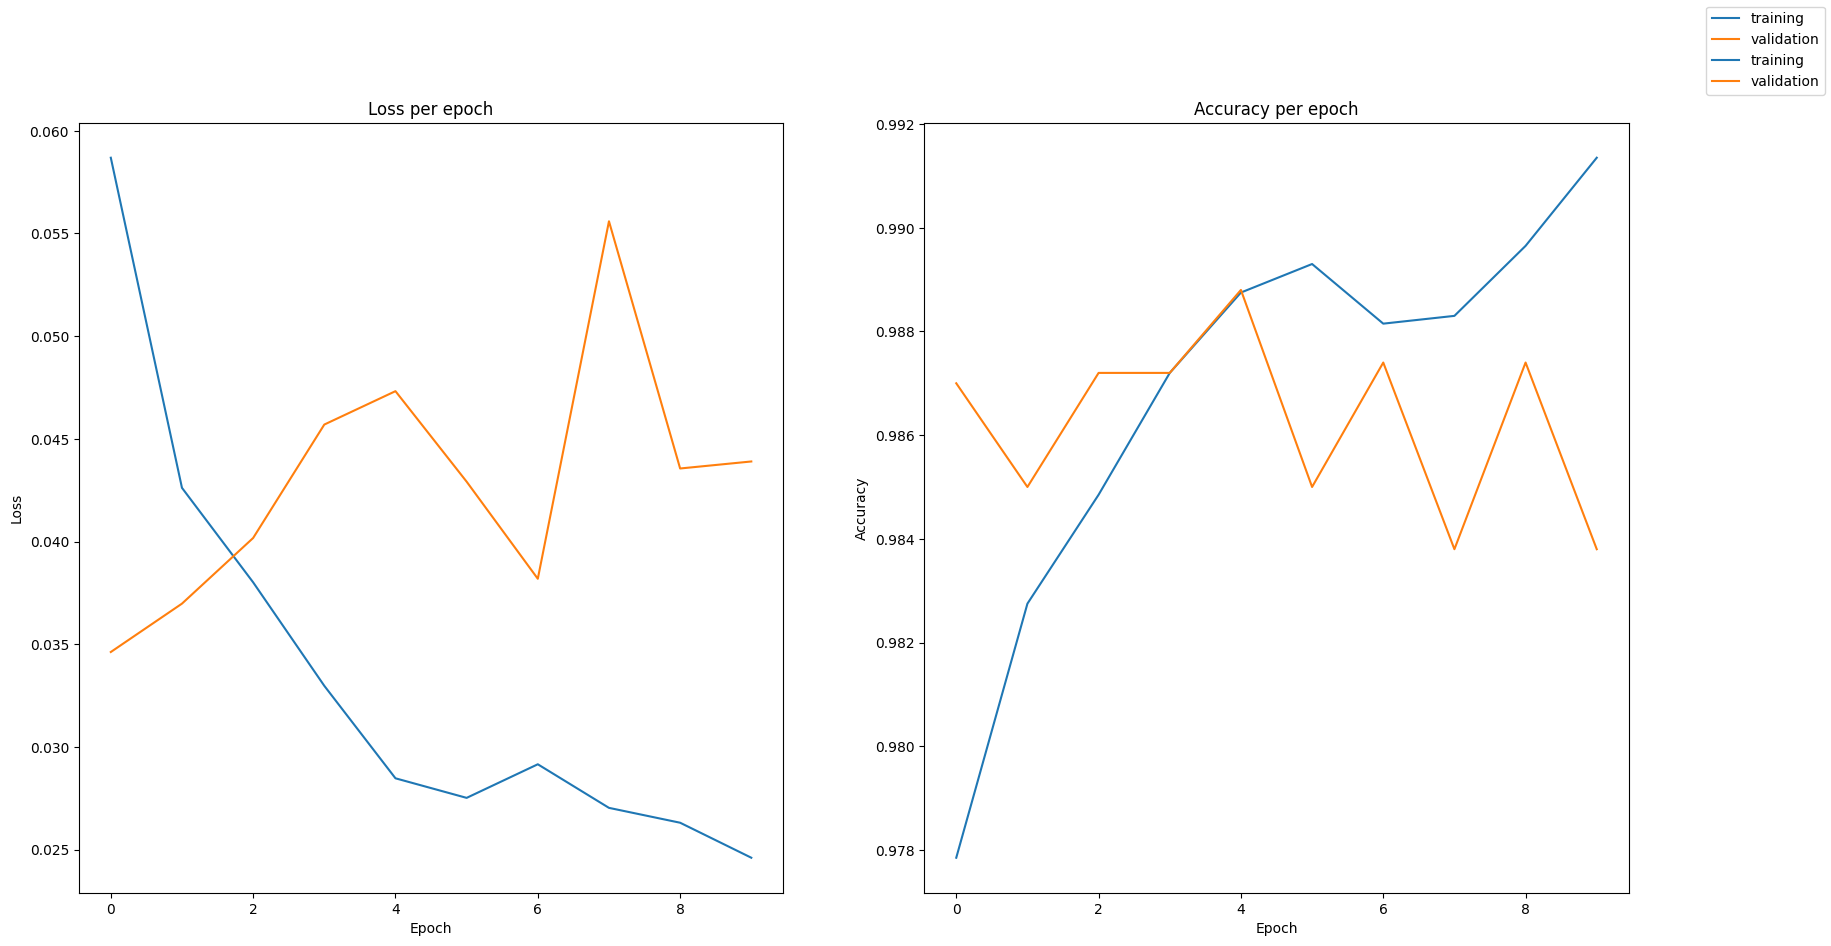

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(history.epoch, history.history['loss'], label='training')
ax[0].plot(history.epoch, history.history['val_loss'], label='validation')
ax[0].set_title('Loss per epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(history.epoch, history.history['accuracy'], label='training')
ax[1].plot(history.epoch, history.history['val_accuracy'], label='validation')
ax[1].set_title('Accuracy per epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy');

fig.legend();

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
y_pred, y_true = [], []
validation_data.reset()
num_batches = int(np.ceil(validation_data.n / (1.0 * validation_data.batch_size)))
for i in range(num_batches):
    y_pred.extend(tf.cast(tf.nn.sigmoid(model.predict(validation_data[i][0], verbose=0)) >= 0.5, dtype=tf.int32).numpy())
    y_true.extend(validation_data[i][1])

    print(f'\r{i+1} out of {num_batches}', end='')

y_pred = np.array([x[0] for x in y_pred])
y_true = np.array(y_true)

79 out of 79

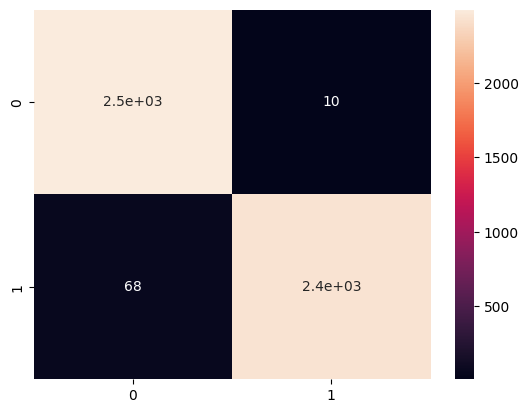

In [17]:
cm = confusion_matrix(y_true, y_pred);

plt.figure()
sns.heatmap(cm, annot=True);

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2500
         1.0       1.00      0.97      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



## Prediction

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [20]:
def predict(model, image_path):
    img = load_img(image_path, target_size=target_size[:-1])
    img = img_to_array(img)
    img = np.expand_dims(img, 0)
    a = model.predict(img, verbose=0)
    return tf.nn.sigmoid(a)

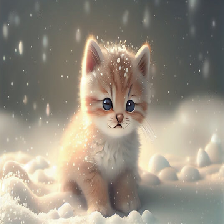

In [25]:
load_img('cat01.jpg', target_size=target_size)

In [34]:
cat_prob = 100 - predict(model, 'cat01.jpg').numpy()[0][0]
print(f'%{cat_prob:.4f}, it is a cat')

%99.9998, it is a cat
